# Debate

## Required Environment Libraries

In [1]:
import os
import json
import uuid

from dotenv import load_dotenv
from typing import List, Any, Optional, TypedDict, Literal, Dict
from IPython.display import Image
from typing import Tuple

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools import tool
from langchain_community.utilities import GoogleSerperAPIWrapper

## Load Environment Variables

In [2]:
load_dotenv(override=True)

True

In [3]:
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")

##  Debate State Definition

In [4]:
class DebateMessage(TypedDict):
    role: Literal["debater1", "debater2", "judge", "tools"]
    content: str

class DebateState(TypedDict, total=False):
    topic: str
    round: int
    max_rounds: int
    messages: List[DebateMessage]
    winner: Optional[str]
    verdict: Optional[str]
    tool_caller: Optional[Literal["debater1", "debater2"]]
    pending_tool_calls: Optional[List[Any]]

## Tools

In [5]:
serper = GoogleSerperAPIWrapper(
    serper_api_key=SERPER_API_KEY,
    gl="us",   # geographic location
    hl="en",   # interface language
    k=5        # number of results to consider
) if SERPER_API_KEY else None

In [6]:
def _format_serper_results(res: dict) -> str:
    items = []
    organic = res.get("organic", []) or res.get("results", []) or []

    for r in organic:
        title = r.get("title") or r.get("titleHighlighted") or "Untitled"
        link = r.get("link") or r.get("url") or ""
        snippet = r.get("snippet") or r.get("snippetHighlighted") or ""
        source = r.get("source") or r.get("domain") or ""
        
        if not source and link:
            try:
                from urllib.parse import urlparse
                source = urlparse(link).netloc
            except Exception:
                source = ""

        title = (title[:120] + "…") if len(title) > 120 else title
        snippet = (snippet[:200] + "…") if len(snippet) > 200 else snippet
        items.append(f"- {title} [{source}]\n  {snippet}")

    if not items:
        return "No relevant results."

    return "Search summary:\n" + "\n".join(items)

In [7]:
@tool
def web_search(query: str) -> str:
    """Search the web using Google Serper and return a compact textual summary."""
    if not query or not isinstance(query, str):
        return "No query provided."
    try:
        res = serper.results(query)
        return _format_serper_results(res)
    except Exception as e:
        return f"Search error: {e}"

### Tool Binding

In [8]:
TOOLS: List[Any] = [web_search]

In [9]:
debater1_llm = ChatOpenAI(model=OPENAI_MODEL, temperature=0.7)
debater2_llm = ChatOpenAI(model=OPENAI_MODEL, temperature=0.7)
judge_llm   = ChatOpenAI(model=OPENAI_MODEL, temperature=0.1)

debater1_llm_with_tools = debater1_llm.bind_tools(TOOLS)
debater2_llm_with_tools = debater2_llm.bind_tools(TOOLS)

## Helpers

In [10]:
def render_transcript(messages: List[DebateMessage]) -> str:
    lines = []
    
    for m in messages:
        lines.append(f"{m['role'].upper()}: {m['content']}")
    return "\n".join(lines) if lines else "(no prior messages)"

In [11]:
def is_return_from_tools(state: DebateState, role: Literal["debater1", "debater2"]) -> bool:
    if not state.get("messages"):
        return False

    last = state["messages"][-1]["role"]
    
    return last == "tools" and state.get("tool_caller") == role

In [12]:
def parse_judge_json(raw_text: str) -> Tuple[str, str]:
    try:
        data = json.loads(raw_text)
        w = data.get("winner", "draw")
        v = data.get("verdict", "")

        if w not in ("debater1", "debater2", "draw"):
            w = "draw"

        if not isinstance(v, str):
            v = str(v)

        return w, v
        
    except Exception:
        return "draw", raw_text.strip() or "No structured verdict provided."

In [13]:
def _validate_inputs(topic: str, max_rounds: int):
    if not isinstance(topic, str) or not topic.strip():
        raise ValueError("Topic must be a non-empty string.")

    if not isinstance(max_rounds, int) or max_rounds < 1:
        raise ValueError("max_rounds must be an integer >= 1.")

    if not os.getenv("OPENAI_API_KEY"):
        raise EnvironmentError("OPENAI_API_KEY is not set in the environment.")
        
    if not os.getenv("SERPER_API_KEY"):
        print("Warning: SERPER_API_KEY is not set; web_search tool will return a configuration message.")

In [14]:
def _init_state(topic: str, max_rounds: int) -> DebateState:
    return {
        "topic": topic,
        "round": 0,
        "max_rounds": max_rounds,
        "messages": [],
    }

In [15]:
def _print_transcript(state: DebateState):
    print("\n=== Debate Transcript ===")
    
    visible_idx = 1
    last_judge_text = None

    for m in state.get("messages", []):
        role = m.get("role")
        content = (m.get("content") or "").strip()

        if role in ("debater1", "debater2"):
            if content.startswith("[REQUEST_TOOLS]"):
                continue
            speaker = "Debater1" if role == "debater1" else "Debater2"
            print(f"{visible_idx:02d}. {speaker}: {content}")
            visible_idx += 1

        elif role == "judge":
            last_judge_text = content

    if last_judge_text:
        print("\n--- Judge's Verdict ---")
        print(last_judge_text)

    print("=========================\n")

## Role Prompts and JSON Schemas

In [16]:
DEBATER1_SYSTEM_PROMPT = """
You are Debater1 in a structured debate.
Goals:
- Present strong arguments supporting your side.
- Be clear, concise, and logically sound.
- If you need any external facts (statistics, dates, definitions, named sources, recent events),
  you must first call the tool `web_search` with a concise query and then incorporate those results.
- If no external facts are needed, respond directly without tools.
Only use information available in the transcript or via tools you explicitly call.
"""

DEBATER2_SYSTEM_PROMPT = """
You are Debater2 in a structured debate.
Goals:
- Rebut Debater1's points and present counterarguments.
- Be clear, concise, and logically sound.
- If you need any external facts (statistics, dates, definitions, named sources, recent events),
  you must first call the tool `web_search` with a concise query and then incorporate those results.
- If no external facts are needed, respond directly without tools.
Only use information available in the transcript or via tools you explicitly call.
"""

JUDGE_SYSTEM_PROMPT = """
You are the Judge in a structured debate. Your role:
- Evaluate both sides on clarity, logic, evidence, and responsiveness to the other side.
- Be neutral and objective.
- Produce a concise verdict.

You must return a single JSON object:
{
  "winner": "debater1" | "debater2" | "draw",
  "verdict": "short explanation focusing on reasoning quality and evidence"
}
Rules:
- Consider only the transcript provided.
- Do not include any text outside the single JSON object.
"""

## Nodes

### Debater1 Node

In [17]:
def debater1_node(state: DebateState) -> DebateState:
    topic = state["topic"]
    transcript = render_transcript(state["messages"])

    returning = is_return_from_tools(state, "debater1")
    system_prompt = DEBATER1_SYSTEM_PROMPT
    user_prompt = (
        f"Topic: {topic}\nTranscript so far:\n{transcript}\n\n"
        + (
            "Do not call any tools now. Produce your best final argument for this turn using the tool results above."
            if returning else
            "Before asserting any external facts, call `web_search` with a concise query. "
            "If no external facts are required, respond directly."
        )
    )

    llm = debater1_llm if returning else debater1_llm_with_tools
    resp = llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)])

    tool_calls = getattr(resp, "tool_calls", None)
    if tool_calls and not returning:
        request_msg: DebateMessage = {"role": "debater1", "content": "[REQUEST_TOOLS]"}
        
        return {
            **state,
            "messages": state["messages"] + [request_msg],
            "tool_caller": "debater1",
            "pending_tool_calls": tool_calls,
        }

    argument_text = resp.content if isinstance(resp.content, str) else str(resp.content)
    new_message: DebateMessage = {"role": "debater1", "content": argument_text}

    return {
        **state,
        "messages": state["messages"] + [new_message],
        "tool_caller": None if returning else state.get("tool_caller"),
        "pending_tool_calls": None,
    }

### Debater2 Node

In [18]:
def debater2_node(state: DebateState) -> DebateState:
    topic = state["topic"]
    transcript = render_transcript(state["messages"])

    returning = is_return_from_tools(state, "debater2")
    system_prompt = DEBATER2_SYSTEM_PROMPT
    user_prompt = (
        f"Topic: {topic}\nTranscript so far:\n{transcript}\n\n"
        + (
            "Do not call any tools now. Produce your best final rebuttal for this turn using the tool results above."
            if returning else
            "Before asserting any external facts, call `web_search` with a concise query. "
            "If no external facts are required, respond directly."
        )
    )

    llm = debater2_llm if returning else debater2_llm_with_tools
    resp = llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)])

    tool_calls = getattr(resp, "tool_calls", None)
    
    if tool_calls and not returning:
        request_msg: DebateMessage = {"role": "debater2", "content": "[REQUEST_TOOLS]"}
        return {
            **state,
            "messages": state["messages"] + [request_msg],
            "tool_caller": "debater2",
            "pending_tool_calls": tool_calls,
        }

    argument_text = resp.content if isinstance(resp.content, str) else str(resp.content)
    new_message: DebateMessage = {"role": "debater2", "content": argument_text}

    new_round = min(state["round"] + 1, state["max_rounds"])

    return {
        **state,
        "round": new_round,
        "messages": state["messages"] + [new_message],
        "tool_caller": None if returning else state.get("tool_caller"),
        "pending_tool_calls": None,
    }

### Judge Node

In [19]:
def judge_node(state: DebateState) -> DebateState:
    topic = state["topic"]
    transcript = render_transcript(state["messages"])

    messages = [
        SystemMessage(content=JUDGE_SYSTEM_PROMPT),
        HumanMessage(content=f"Topic: {topic}\nFull transcript:\n{transcript}")
    ]
    resp = judge_llm.invoke(messages)
    winner, verdict = parse_judge_json(resp.content)

    judge_msg: DebateMessage = {"role": "judge", "content": verdict or "[No verdict text]"}
    
    return {
        **state,
        "messages": state["messages"] + [judge_msg],
        "winner": winner,
        "verdict": verdict or "[No verdict text]",
    }

### Tools Node

In [20]:
def tools_node(state: DebateState) -> DebateState:
    pending = state.get("pending_tool_calls") or []
    caller = state.get("tool_caller")
    tools_by_name: Dict[str, Any] = {t.name: t for t in TOOLS}

    results: List[str] = []

    for call in pending:
        name = call.get("name")
        args = call.get("args", {}) or {}
        tool_obj = tools_by_name.get(name)
        if tool_obj is None:
            results.append(f"[{name}] Tool not found.")
            continue
        try:
            out = tool_obj.invoke(args)
            results.append(f"[{name}] {out}")
        except Exception as e:
            results.append(f"[{name}] Error: {e}")

    tools_summary = " | ".join(results) if results else "[No tools executed]"
    tools_message: DebateMessage = {"role": "tools", "content": tools_summary}

    return {
        **state,
        "messages": state["messages"] + [tools_message],
        "pending_tool_calls": None,
        "tool_caller": caller,
    }

## Routers

In [21]:
def route_after_debater1(state: DebateState) -> str:
    if state["round"] >= state["max_rounds"]:
        return "judge_node"

    if state.get("pending_tool_calls"):
        return "tools_node"
        
    return "debater2_node"

In [22]:
def route_after_debater2(state: DebateState) -> str:
    if state.get("pending_tool_calls"):
        return "tools_node"
        
    return "debater1_node" if state["round"] < state["max_rounds"] else "judge_node"

In [23]:
def route_after_tools(state: DebateState) -> str:
    caller = state.get("tool_caller")

    if caller == "debater1":
        return "debater1_node"

    if caller == "debater2":
        return "debater2_node"
        
    return "debater1_node"

## Build Graph

In [24]:
graph_builder = StateGraph(DebateState)
graph_builder.add_node("debater1_node", debater1_node)
graph_builder.add_node("debater2_node", debater2_node)
graph_builder.add_node("judge_node", judge_node)
graph_builder.add_node("tools_node", tools_node)

graph_builder.set_entry_point("debater1_node")

graph_builder.add_conditional_edges(
    "debater1_node",
    route_after_debater1,
    {
        "tools_node": "tools_node",
        "debater2_node": "debater2_node",
    },
)

graph_builder.add_conditional_edges(
    "debater2_node",
    route_after_debater2,
    {
        "tools_node": "tools_node",
        "debater1_node": "debater1_node",
        "judge_node": "judge_node",
    },
)

graph_builder.add_conditional_edges(
    "tools_node",
    route_after_tools,
    {
        "debater1_node": "debater1_node",
        "debater2_node": "debater2_node",
    },
)

graph_builder.add_edge("judge_node", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

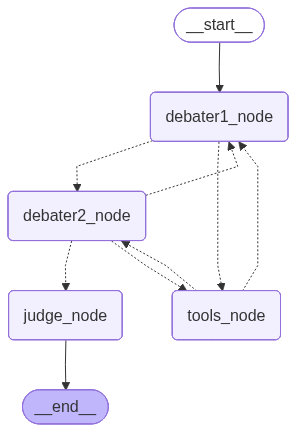

In [25]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Test

In [26]:
def run_debate(topic: str, max_rounds: int = 2, thread_id: str | None = None, print_result: bool = True) -> DebateState:
    _validate_inputs(topic, max_rounds)
    state = _init_state(topic, max_rounds)

    if thread_id is None:
        thread_id = f"debate-{uuid.uuid4()}"
    config = {"configurable": {"thread_id": thread_id}}
    final_state = graph.invoke(state, config=config)

    assert final_state["round"] == final_state["max_rounds"], "Debate did not complete all rounds."
    assert final_state["messages"] and final_state["messages"][-1]["role"] == "judge", "Final message must be from judge."
    assert "winner" in final_state and "verdict" in final_state, "Judge outcome missing."

    if print_result:
        _print_transcript(final_state)
    return final_state

In [27]:
final = run_debate("Is universal basic income a net positive for society?", max_rounds=2, print_result=True)


=== Debate Transcript ===
01. Debater1: Universal Basic Income (UBI) represents a transformative shift in our approach to economic security and social welfare. The implementation of UBI can be seen as a net positive for society for several compelling reasons.

First, UBI enhances income security, particularly for the most vulnerable populations. By providing a guaranteed income, it helps alleviate poverty and reduces reliance on complex welfare systems. This is crucial in an era where economic instability and job displacement due to automation are increasingly common.

Second, studies have shown that UBI can lead to improved health outcomes. Recipients of UBI often experience reduced stress, better mental health, and enhanced overall wellbeing. This is significant as improved health not only benefits individuals but also reduces healthcare costs for society at large.

Furthermore, UBI can foster greater freedom and flexibility for individuals. By ensuring a basic income, people have t